### Data 620 - Project 2
### Bikram Barua and Leticia Salazar
### March 12, 2023

#### Task:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

#### Data source:

We decided to continue working with our project 1 dataset since it's a 2 node network to further explore the dataset and be able to create better visualizations. This dataset was obtained from [Network Repository](https://networkrepository.com/socfb-Cornell5.php) consisting of people (nodes) and their friendship ties (edges) on Facebook. The data is available in a matrix market, typically a sparse format used to represent a matrix (.mtx file). With these types of files, the first line contains a header with information about the matrix, dimensions, and symmetry of the matrix. The following lines are non-zero entries of the matrix in row-major order, with each following line containing the row index, column index, and a value of a single non-zero entry.

Below are some specs from this dataset provided by the repository:

* Nodes: 18.7K
* Edges: 790.8K
* Density: 0.00454239
* Maximum degree: 3.2K
* Minimum degree: 1
* Average degree: 84
* Assortativity: 0.01805
* Number of triangles: 18.3M
* Average number of triangles: 982
* Maximum number of triangles: 77.2K
* Average clustering coefficient: 0.219051
* Fraction of closed triangles: 0.135615
* Maximum k-core: 85
* Lower bound of Maximum Clique: 13

#### Load libraries:

Below are the libraries used

In [41]:
# data manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm #Instantly make your loops show a smart progress meter 
import random 
from scipy import stats
import csv
import math

# data visualization
import networkx as nx
import matplotlib.pyplot as plt
from networkx_viewer import Viewer
from pyvis.network import Network # interactive graph

# Import bi-partite (bi-modal) functions
from networkx.algorithms import bipartite as bi
import networkx as net

##### Load the data:
As mentioned, the original file is too large and had to be split to contain 5000 variables only.

In [42]:
# load 2 mode network 
df = pd.read_csv('fb_split.csv')
df

,Person,Friendships
0,184,1
1,344,1
2,635,1
3,867,1
4,1296,1
...,...,...
4995,13909,67
4996,13940,67
4997,14294,67
4998,14361,67


In [43]:
df.shape

(5000, 2)

With our data we have 4,085 unique person's so we know there are a couple of people that are duplicated or have multiple connections.

In [44]:
df.Person.nunique()

4085

In [45]:
df.Person.value_counts()

17027    11
8201      7
16112     7
12797     7
9651      6
         ..
12168     1
12406     1
12933     1
13305     1
13940     1
Name: Person, Length: 4085, dtype: int64

#### Calculating degree and eigenvector centrality for the dataset.

For both degree and eigenvector centrality, we created a column for the calculations to have their own column and then merged these columns into our dataset separately.

In [48]:
# start networkX
G = nx.Graph()

# degree centrality
degree = nx.degree(G)
df_2 = pd.DataFrame(degree, columns = ['Person','Degree_Cent'])
df_2 = pd.merge(df_2, df, on='Person', how='inner')
df2 = df_2.sort_values('Degree_Cent', ascending = False)
df2.head()

,Degree_Cent,Person,Friendships


The following code was obtained from a YouTube video in which we use the loaded csv file to create our networkx graph

In [7]:
# defining the list of nodes from our columns
person = list(df['Person'])
friendships = list(df['Friendships'])

In [8]:
# Since we have a repeated elements since this is an edgelist we have
# ensure that we extract the set of our columns
set_person = set(person)
set_friendships = set(friendships)

In [9]:
# checking how many person's and frienships we have in our data set
# note: that we have 4085 unique values now
print("The number of person's = ", len(set_person))
print("The number of frienships' = ", len(set_friendships))

The number of person's =  4085
The number of frienships' =  67


#### Start creating the network

In [10]:
# top and bottom references the list of person's (top) and friendships (bottom)
def create_from_edgelist(top,bottom): 
    
    # creating graph
    B = nx.Graph()
    
    # iterating through each row since each one is an edge 
    for i in range(len(top)):
        B.add_node(top[i], bipartite=0)
        B.add_node(bottom[i], bipartite=1)
        B.add_edge(top[i], bottom[i])
    return B

# assign the list we created in cell 7
B = create_from_edgelist(person,friendships)

print("The number of nodes = ", len(B.nodes))
print("The number of edges = ", len(B.edges))

The number of nodes =  4147
The number of edges =  5000


Now we are getting ready to plot. In this case, to show the edges and nodes we define each individually. The results are below:

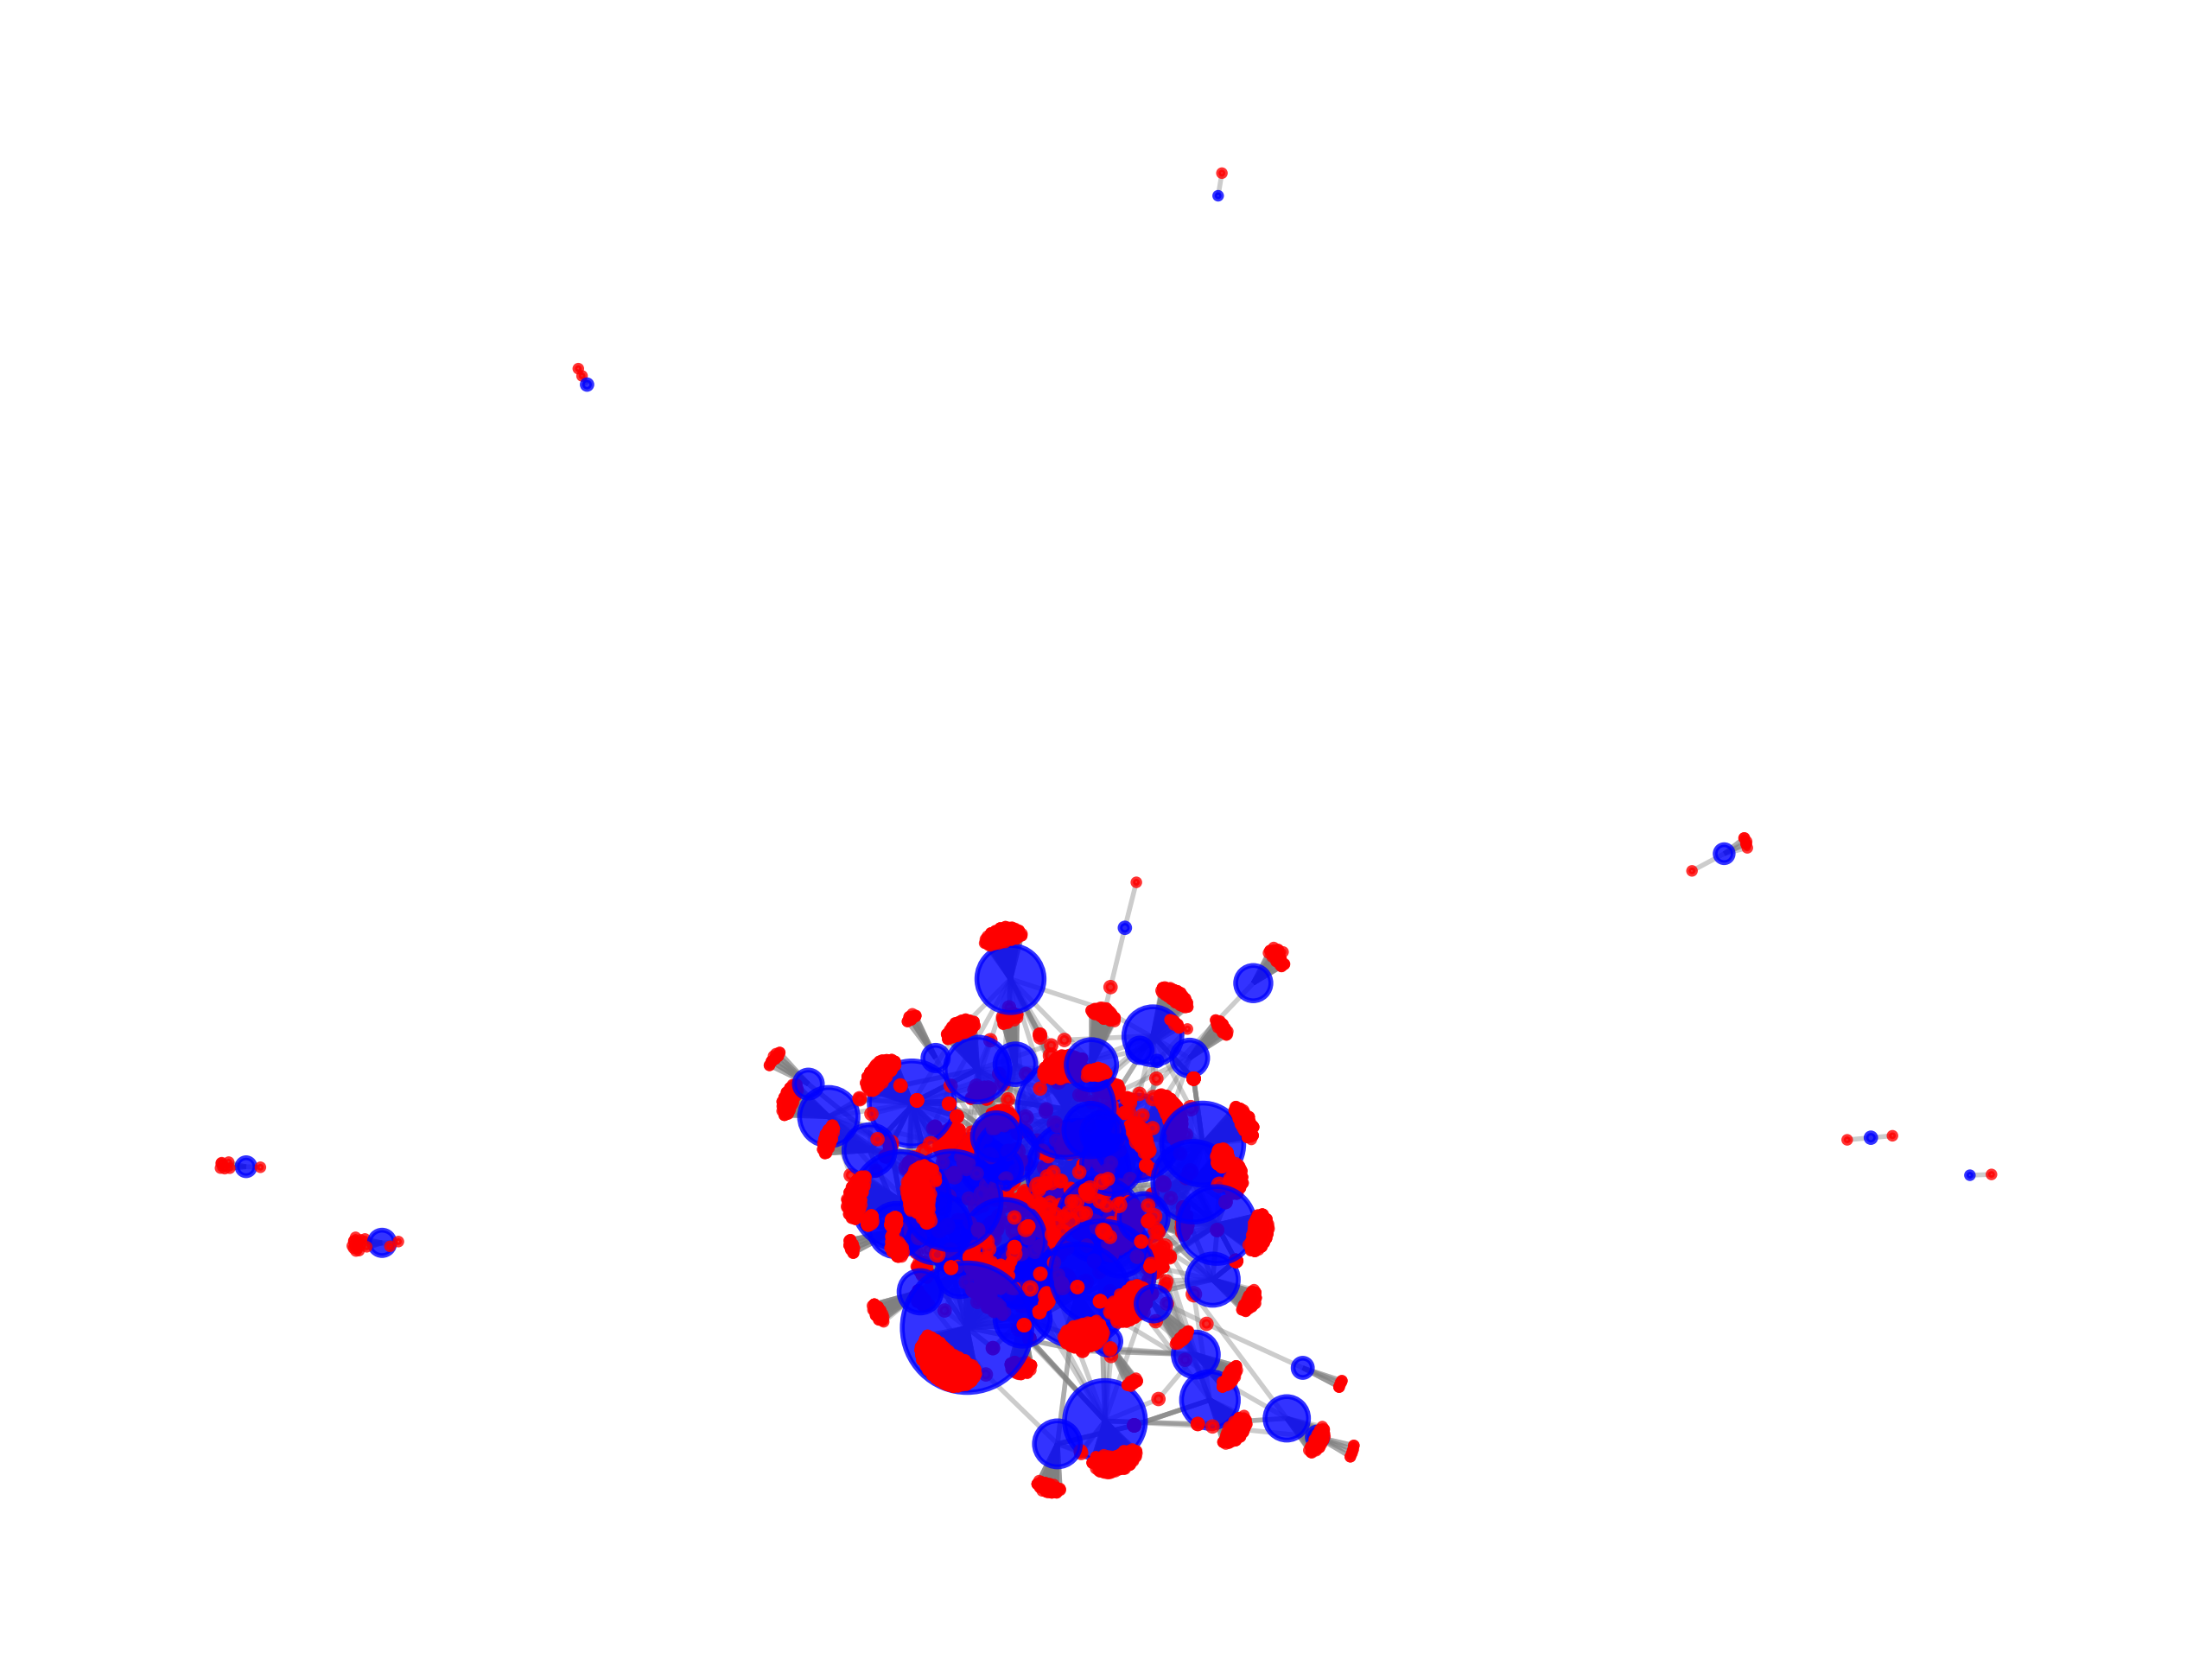

In [11]:
# Creating environment for figure
f = plt.figure(1,figsize=(8,6), dpi=400)

# defining layout
pos = nx.spring_layout(B)

colors = {0:'r', 1:'b'}

# defining nodes
nx.draw_networkx_nodes(B, pos=pos, \
                      node_size=[B.degree[node]*2 for node in B], \
                      alpha=0.8, \
                      node_color=[colors[B.nodes[node]['bipartite']] for node in B])

# definging the edges
nx.draw_networkx_edges(B, pos=pos, alpha=0.4, \
                      edge_color = 'gray')

plt.axis('off')
plt.show()

Since we have a lot of connections it's hard to visualize the graph, so we created an interactive graph using Pyvis and the results are below:

In [1]:
# create vis network
#net = Network(notebook=True)
# load the networkx graph
#net.from_nx(B)
# show
#net.show("graph1.html")

#### Island Method

The following code was taken from SNAS Chapter 4 to perform the island method which is used to analyze networks. 

In [28]:
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [29]:
person_weighted = bi.weighted_projected_graph(B, set_person, ratio=False)
friendships_weighted = bi.weighted_projected_graph(B, set_friendships, ratio=False)

In [30]:
# applying island method to the person_weighted
person_thresholds = island_method(person_weighted)

Since I am working with NetworkX 3.0 I had to make some adjustments to the print out line. In the book the code is show as: `print i[0], len(i[1]), len(net.connected_component_subgraphs(i[1]))`, when running this code I get an attribute error for `net.connected_component_subgraphs`. 

After adjustments the results are below:

In [31]:
# print the threshold level, size of the graph, and number of connected components

#print("threshold level, size of graph, # of connected components")
#for i in person_thresholds:
    #print(i[0], "\t\t", len(i[1]),"\t\t", len(list(person_weighted.subgraph(c) for c in nx.connected_components(i[1]))))

print("Threshold, Nodes, Edges, Number of Connected Components")
for i in person_thresholds:
    print(i[0], "\t\t", nx.number_of_nodes(i[1]), "\t\t", nx.number_of_edges(i[1]), "\t\t", nx.number_connected_components(i[1]))

Threshold, Nodes, Edges, Number of Connected Components
1 		 667 		 4805 		 42
11 		 10 		 8 		 3
21 		 6 		 4 		 2
31 		 5 		 3 		 2
41 		 2 		 1 		 1
51 		 2 		 1 		 1


In [32]:
# applying the island method to the friendships_weighted
friendships_thresholds = island_method(friendships_weighted)

In [33]:
# print the threshold level, size of the graph, and number of connected components

#print("threshold level, size of graph, # of connected components")
#for i in friendships_thresholds:
    #print(i[0], "\t\t", len(i[1]),"\t\t", len(list(friendships_weighted.subgraph(c) for c in nx.connected_components(i[1]))))
    
print("Threshold, Nodes, Edges, Number of Connected Components")
for i in friendships_thresholds:
    print(i[0], "\t\t", nx.number_of_nodes(i[1]), "\t\t", nx.number_of_edges(i[1]), "\t\t", nx.number_connected_components(i[1]))

Threshold, Nodes, Edges, Number of Connected Components
1 		 64 		 221 		 1
11 		 13 		 11 		 3
21 		 6 		 4 		 2
31 		 5 		 3 		 2
41 		 2 		 1 		 1
51 		 2 		 1 		 1


After perfoming the island method it is good to visualize our findings. We created 4 iterations for Person and Friendships of which the start is pretty clustered.

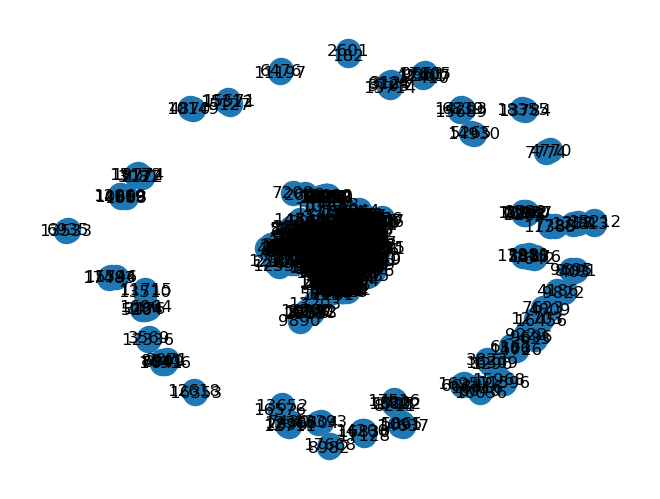

In [34]:
# drawing the person_weights
person_weights = [math.log(float(edata['weight'])) for f, t, edata in person_thresholds[0][1].edges(data=True)]
nx.draw_spring(person_thresholds[0][1], width=person_weights, edge_color=person_weights, with_labels=True)

#see data
#person_thresholds[0][1].edges(data=True)

The first iteration for Person shows person 44 and 39 having the highest weight of 52 and holds true for the following iterations. This is also relevant for frienships where 44 and 49 hold the highest weight of 52.

EdgeDataView([(44, 39, {'weight': 52}), (47, 15, {'weight': 35}), (47, 62, {'weight': 24}), (47, 67, {'weight': 39}), (15, 67, {'weight': 16}), (56, 8, {'weight': 14}), (56, 25, {'weight': 13}), (56, 30, {'weight': 21})])

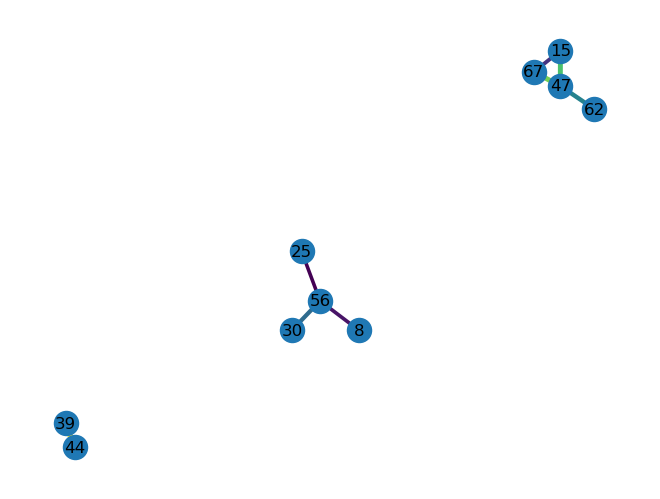

In [35]:
# first iteration of person_weights
person_weights = [math.log(float(edata['weight'])) for f, t, edata in person_thresholds[1][1].edges(data=True)]
nx.draw_spring(person_thresholds[1][1], width=person_weights, edge_color=person_weights, with_labels=True)

#see data
person_thresholds[1][1].edges(data=True)

EdgeDataView([(44, 39, {'weight': 52}), (47, 15, {'weight': 35}), (47, 62, {'weight': 24}), (47, 67, {'weight': 39})])

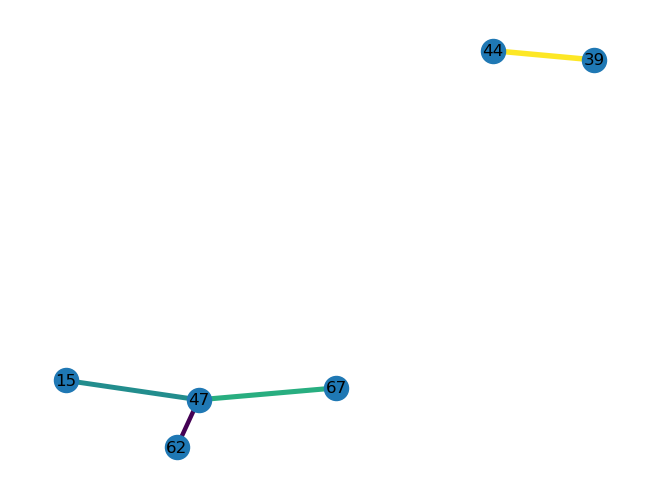

In [36]:
# second iteration of person_weights
person_weights = [math.log(float(edata['weight'])) for f, t, edata in person_thresholds[2][1].edges(data=True)]
nx.draw_spring(person_thresholds[2][1], width=person_weights, edge_color=person_weights, with_labels=True)

#see data
person_thresholds[2][1].edges(data=True)

EdgeDataView([(44, 39, {'weight': 52}), (47, 15, {'weight': 35}), (47, 67, {'weight': 39})])

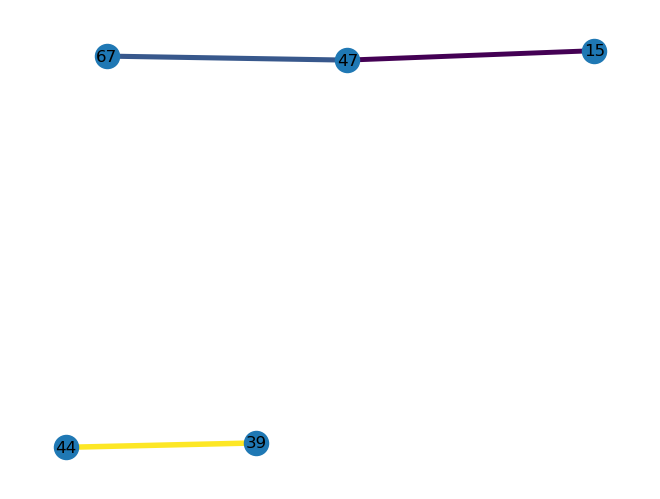

In [37]:
# third iteration of person_weights
person_weights = [math.log(float(edata['weight'])) for f, t, edata in person_thresholds[3][1].edges(data=True)]
nx.draw_spring(person_thresholds[3][1], width=person_weights, edge_color=person_weights, with_labels=True)

#see data
person_thresholds[3][1].edges(data=True)

EdgeDataView([(44, 39, {'weight': 52})])

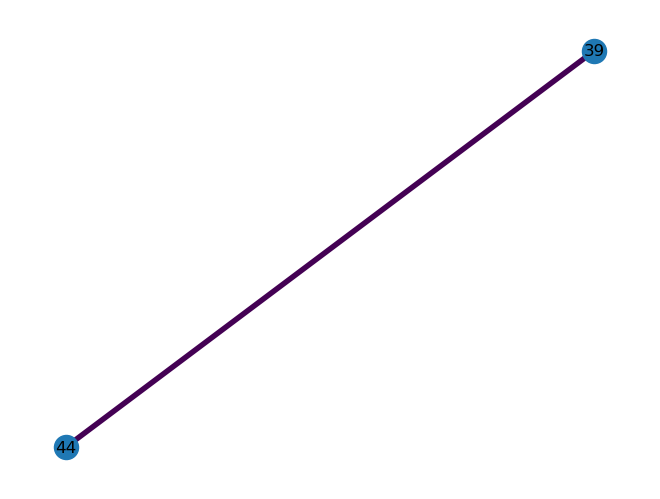

In [38]:
# fourth iteration of person_weights
person_weights = [math.log(float(edata['weight'])) for f, t, edata in person_thresholds[4][1].edges(data=True)]
nx.draw_spring(person_thresholds[4][1], width=person_weights, edge_color=person_weights, with_labels=True)

#see data
person_thresholds[4][1].edges(data=True)

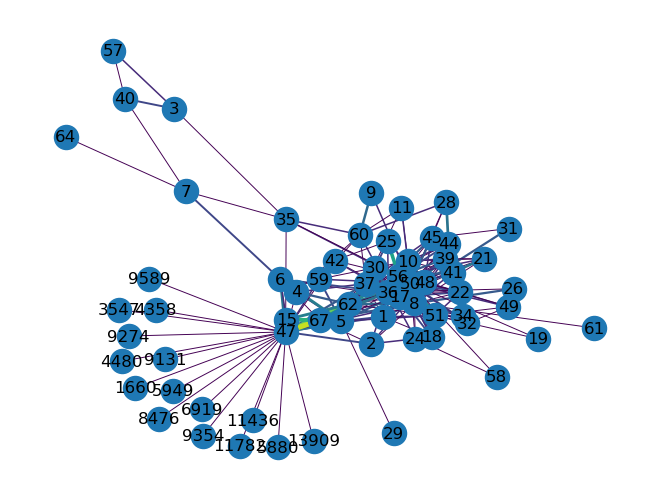

In [39]:
# drawing friendship_weights
friendships_weights = [math.log(float(edata['weight'])) for f, t, edata in friendships_thresholds[0][1].edges(data=True)]
nx.draw_spring(friendships_thresholds[0][1], width=friendships_weights, edge_color=friendships_weights, with_labels=True)

#see data
#person_thresholds[0][1].edges(data=True)

EdgeDataView([(8, 36, {'weight': 15}), (8, 56, {'weight': 14}), (36, 48, {'weight': 13}), (56, 25, {'weight': 13}), (56, 30, {'weight': 21}), (10, 48, {'weight': 14}), (15, 47, {'weight': 35}), (15, 67, {'weight': 16}), (47, 62, {'weight': 24}), (47, 67, {'weight': 39}), (39, 44, {'weight': 52})])

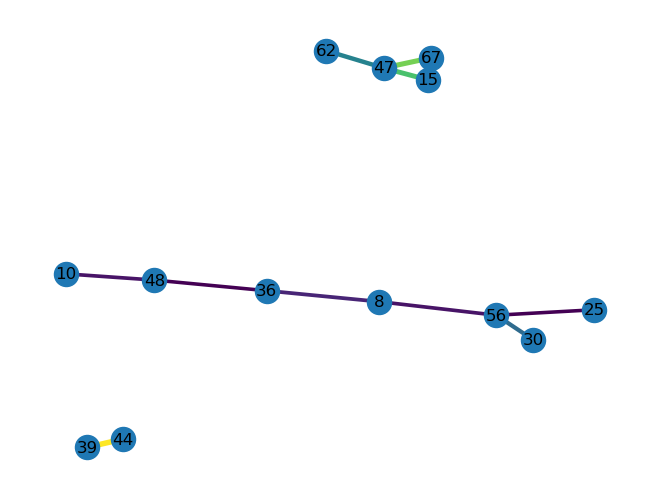

In [40]:
# first iteration of friendships_weights
friendships_weights = [math.log(float(edata['weight'])) for f, t, edata in friendships_thresholds[1][1].edges(data=True)]
nx.draw_spring(friendships_thresholds[1][1], width=friendships_weights, edge_color=friendships_weights, with_labels=True)

#see data
friendships_thresholds[1][1].edges(data=True)

EdgeDataView([(15, 47, {'weight': 35}), (47, 62, {'weight': 24}), (47, 67, {'weight': 39}), (39, 44, {'weight': 52})])

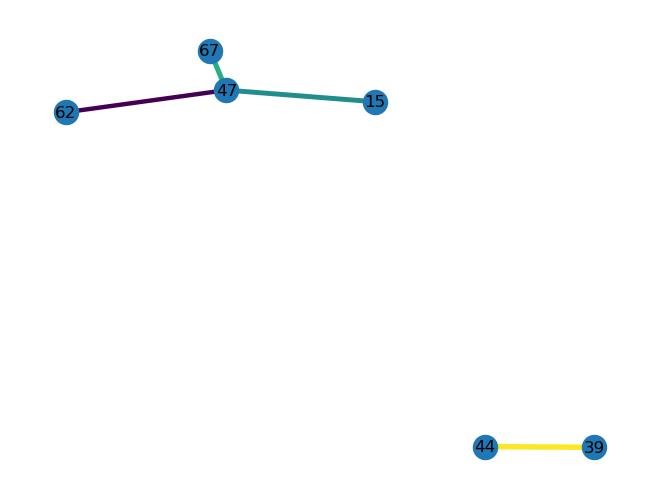

In [25]:
# second iteration of friendships_weights
friendships_weights = [math.log(float(edata['weight'])) for f, t, edata in friendships_thresholds[2][1].edges(data=True)]
nx.draw_spring(friendships_thresholds[2][1], width=friendships_weights, edge_color=friendships_weights, with_labels=True)

#see data
friendships_thresholds[2][1].edges(data=True)

EdgeDataView([(15, 47, {'weight': 35}), (47, 67, {'weight': 39}), (39, 44, {'weight': 52})])

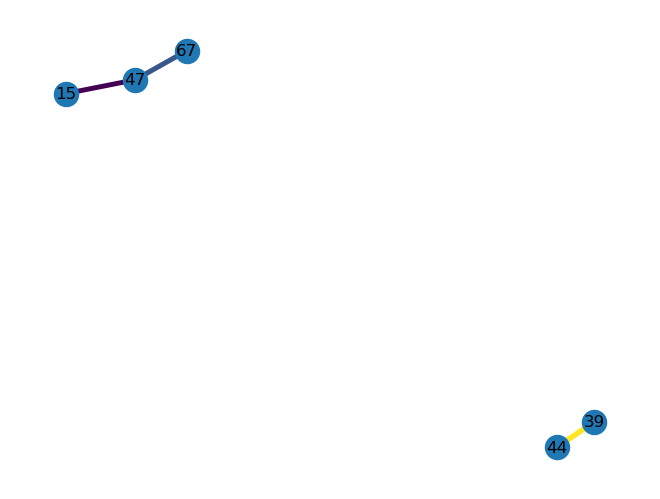

In [26]:
# third iteration of friendships_weights
friendships_weights = [math.log(float(edata['weight'])) for f, t, edata in friendships_thresholds[3][1].edges(data=True)]
nx.draw_spring(friendships_thresholds[3][1], width=friendships_weights, edge_color=friendships_weights, with_labels=True)

#see data
friendships_thresholds[3][1].edges(data=True)

EdgeDataView([(39, 44, {'weight': 52})])

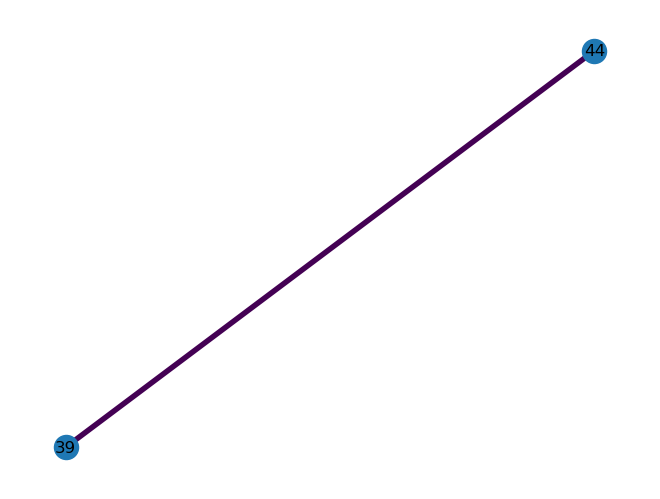

In [27]:
# fourth iteration of friendships_weights
friendships_weights = [math.log(float(edata['weight'])) for f, t, edata in friendships_thresholds[4][1].edges(data=True)]
nx.draw_spring(friendships_thresholds[4][1], width=friendships_weights, edge_color=friendships_weights, with_labels=True)

#see data
friendships_thresholds[4][1].edges(data=True)

#### Conclusion:

Based on my interpretation we can infer that with this split dataset the island method did significantly reduce the connections in order to view those that carry the most weight. Although after looking it thoroughly it seems like Persons and Frienships have the same two Persons (users) who have the highest weighted values. Changes were made to the code but still get the same results. Possibly would like to see how this method would work on the entire dataset and if there are any significant changes.

#### References:

* Mayank, M. (2021, February 1). Visualizing Networks in python. Medium. Retrieved March 10, 2023, from https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259 
* YouTube. (2021, July 8). Analysis of two-mode networks with Python | Demival vasques filho. YouTube. Retrieved March 10, 2023, from https://www.youtube.com/watch?v=CcOfX4n4pWg 
* Network Analysis in Python: Projected_graph. projected_graph - NetworkX 3.0 documentation. (n.d.). Retrieved March 10, 2023, from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.projection.projected_graph.html 
* Attributeerror: Module 'networkx' has no attribute 'connected_component_subgraphs'. Stack Overflow. (1967, February 1). Retrieved March 12, 2023, from https://stackoverflow.com/questions/61154740/attributeerror-module-networkx-has-no-attribute-connected-component-subgraph 